In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
from sasc import analyze_helper
import sasc.viz
from sasc.modules.fmri_module import convert_module_num_to_voxel_num
from sasc.config import FMRI_DIR, RESULTS_DIR
import dvu
dvu.set_style()

[2023-11-22 16:13:16,803] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


# Specify which directory the resps are in and which stories to load

In [2]:
pilot_name = 'pilot3_story_data.pkl'

stories_data_dict = joblib.load(
    join(sasc.config.RESULTS_DIR, pilot_name))
if pilot_name == 'pilot2_story_data.pkl':
    pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230702'
elif pilot_name == 'pilot3_story_data.pkl':
    pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20231106'

In [3]:
# load responses
interaction_story_idxs = np.where(
    np.array(stories_data_dict['story_setting']) == 'interactions')[0]
resp_np_files = [stories_data_dict['story_name_new'][i].replace('_resps', '')
                 for i in interaction_story_idxs]
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}


mats_target = defaultdict(list)
for use_clusters in [False]:
    for story_num in interaction_story_idxs:
        print(story_num, stories_data_dict["story_name_new"][story_num])
        story_metadata = stories_data_dict["rows"][story_num]

        # get resp_chunks
        resp_story = resps_dict[
            stories_data_dict["story_name_new"][story_num].replace(
                '_resps', '')
        ].T  # (voxels, time)
        timing = stories_data_dict["timing"][story_num]
        if 'paragraphs' in stories_data_dict.keys():
            paragraphs = stories_data_dict["paragraphs"][story_num]
        else:
            paragraphs = stories_data_dict["story_text"][story_num].split(
                "\n\n")
        # paragraphs = stories_data_dict["paragraphs"][story_num]
        assert len(paragraphs) == len(story_metadata)
        resp_chunks = analyze_helper.get_resps_for_paragraphs(
            timing, paragraphs, resp_story, offset=2)
        # print(
        #     "times",
        #     timing["time_running"].max(),
        #     "resp TRs",
        #     resp_story.shape[1],
        #     "doubled",
        #     resp_story.shape[1] * 2,
        # )

        voxel_num1 = stories_data_dict['voxel_num1'][story_num]
        voxel_num2 = stories_data_dict['voxel_num2'][story_num]
        expl1 = stories_data_dict['expl1'][story_num]
        expl2 = stories_data_dict['expl2'][story_num]

        print(f'{story_num=} {len(story_metadata)=} {len(paragraphs)=} {len(resp_chunks)=} {len(voxel_num1)=} {len(voxel_num2)=}')
        assert len(story_metadata) == len(voxel_num1) * 3 + \
            1, 'Should have a leading paragraph then 3 paragraphs per voxel'

        # calculate mat (rows has an extra leading row which we ignore)
        mat1 = np.zeros((len(voxel_num1), len(paragraphs)))
        mat2 = np.zeros((len(voxel_num2), len(paragraphs)))

        for i in range(len(paragraphs)):
            if i >= len(resp_chunks):
                print('break', i)
                mat1[:, i] = np.nan
                mat2[:, i] = np.nan
                break
            if use_clusters == False:
                mat1[:, i] = np.nanmean(resp_chunks[i][voxel_num1], axis=1)
                mat2[:, i] = np.nanmean(resp_chunks[i][voxel_num2], axis=1)
            # elif use_clusters == True:
            #     for r in range(len(rows)):
            #         cluster_nums = rows.iloc[r]["cluster_nums"]
            #         if isinstance(cluster_nums, np.ndarray):
            #             vals = resp_chunks[i][cluster_nums].flatten()
            #             mat1[r, i] = np.nanmean(vals)
            #         else:
            #             # print(cluster_nums)
            #             mat1[r, i] = np.nan

        mat1 = mat1[:, 1:]  # ignore the first column
        mat2 = mat2[:, 1:]  # ignore the first column

        # select the appropriate columns based on what we are trying to maximize
        mat_target = np.zeros((mat1.shape[0] * 3, mat1.shape[1]))
        for i in range(0, mat_target.shape[0], 3):
            i3 = i // 3
            mat_target[i] = mat1[i3]  # - mat2[i3]
            mat_target[i + 1] = (mat1[i3] + mat2[i3]) / 2
            mat_target[i + 2] = mat2[i3]  # - mat1[i3]

        # Plot each individual mat
        # plt.subplot(131)
        # plt.imshow(mat1)
        # plt.xlabel('Driving paragraph')
        # plt.ylabel('Voxel')
        # plt.title('Voxel 1')
        # plt.subplot(132)
        # plt.imshow(mat2)
        # plt.title('Voxel 2')
        # plt.subplot(133)
        # plt.title('Voxel 1 + 2')
        # mat3 = mat1 + mat2
        # plt.imshow(mat3)
        # plt.show()

        # sort by voxel_num1
        args = np.argsort(story_metadata['voxel_num'][1:])
        mat_target = mat_target[args][:, args]
        mats_target[use_clusters].append(deepcopy(mat_target))

        # plt.imshow(mat_target)
        # plt.title('Stitched with target on diagonal')
        # plt.show()

# get expls
story_metadata = story_metadata.sort_values(by="voxel_num")
expls = story_metadata["expl"].values
args1 = np.argsort(voxel_num1).values
voxel_num1 = voxel_num1.values[args1]
voxel_num2 = voxel_num2.values[args1]
expl1 = expl1.values[args1]
expl2 = expl2.values[args1]


m = {}
for use_clusters in [False]:
    # (num_stories, num_voxels, num_paragraphs)
    mats_target[use_clusters] = np.array(mats_target[use_clusters])
    m[use_clusters] = np.nanmean(mats_target[use_clusters], axis=0)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:07<00:00,  3.70s/it]

2 GenStory14_resps.npy
story_num=2 len(story_metadata)=16 len(paragraphs)=16 len(resp_chunks)=16 len(voxel_num1)=5 len(voxel_num2)=5
3 GenStory15_resps.npy
story_num=3 len(story_metadata)=16 len(paragraphs)=16 len(resp_chunks)=15 len(voxel_num1)=5 len(voxel_num2)=5
break 15


### Make average plot

In [4]:
use_clusters = False
mat_target = m[use_clusters]

# remove every third row and column
idxs = np.arange(mat_target.shape[0])
idxs = np.delete(idxs, np.arange(1, mat_target.shape[0], 3))
mat_single = mat_target[idxs, :][:, idxs]

mat_interaction = mat_target[1::3, 1::3]

<>:42: DeprecationWarning: invalid escape sequence '\s'
<>:42: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_810027/1179228696.py:42: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response ($\sigma_f$)')


mean single 0.07831700916957184
mean inter 0.3237253281945668
median 0.28383424580405936


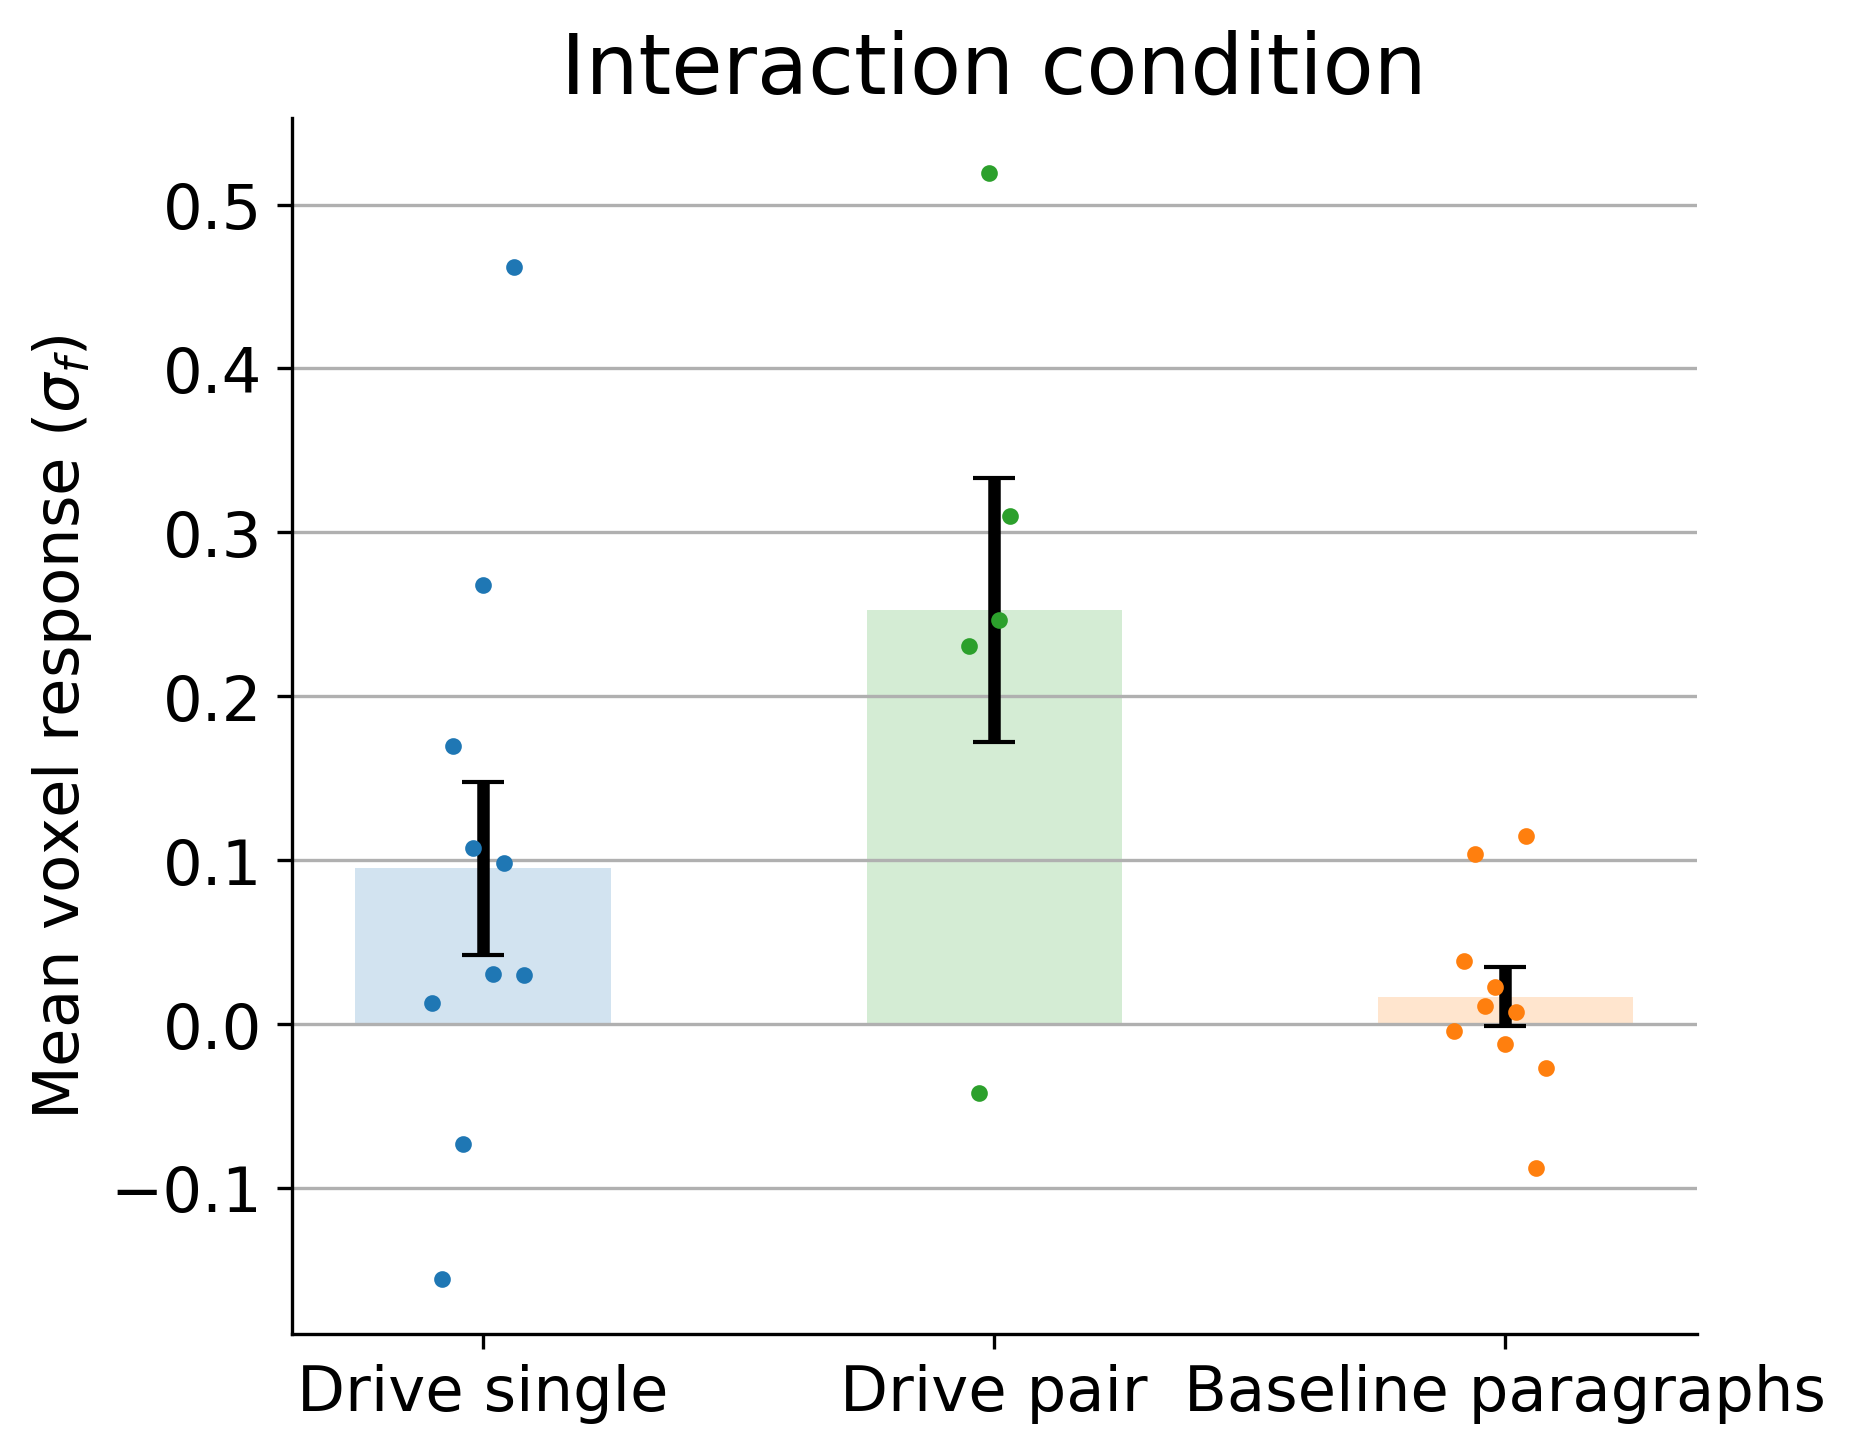

In [5]:
# calculate means
n = mat_single.shape[0]
diag_means = np.diag(mat_single)
diag_mean = np.nanmean(diag_means)

# get mean of each row excluding the diagonal
off_diag_means = np.nanmean(mat_single, axis=1) - (diag_means / n)
off_diag_mean = np.nanmean(off_diag_means)

# make plot
plt.figure(dpi=300)
x = np.arange(n) - n / 2
plt.bar(0, diag_mean, width=0.5, label='Diagonal', alpha=0.2, color='C0')
plt.errorbar(0, diag_mean, yerr=np.nanstd(diag_means) / np.sqrt(len(diag_means)),
             fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5, lw=1)
plt.plot(0 + x/50, diag_means, '.', color='C0')

plt.bar(2, off_diag_mean, width=0.5,
        label='Off-diagonal', alpha=0.2, color='C1')
plt.errorbar(2, off_diag_mean, yerr=np.nanstd(off_diag_means) / np.sqrt(len(off_diag_means)),
             fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5)
plt.plot(2 + x/50, off_diag_means, '.', color='C1')
print('mean single', diag_mean - off_diag_mean)


n = mat_interaction.shape[0]
diag_means = np.diag(mat_interaction)
diag_mean = np.nanmean(diag_means)

# get mean of each row excluding the diagonal
off_diag_means = np.nanmean(mat_interaction, axis=1) - (diag_means / n)
off_diag_mean = np.nanmean(off_diag_means)

# make plot
x = np.arange(n) - n / 2
plt.bar(1, diag_mean, width=0.5, label='Diagonal', alpha=0.2, color='C2')
plt.errorbar(1, diag_mean, yerr=np.nanstd(diag_means) / np.sqrt(len(diag_means)),
             fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5, lw=1)
plt.plot(1 + x/50, diag_means, '.', color='C2')

plt.xticks([0, 1, 2], ['Drive single', 'Drive pair', 'Baseline paragraphs'])
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.grid(axis='y')

plt.tight_layout()
print('mean inter', diag_mean - off_diag_mean)
print('median', np.nanmedian(diag_means) - np.nanmedian(off_diag_means))
plt.title('Interaction condition')
# plt.title(f'use_clusters={use_clusters}')
plt.savefig(join(RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_interaction_means.pdf'))

### Relationship between different voxels

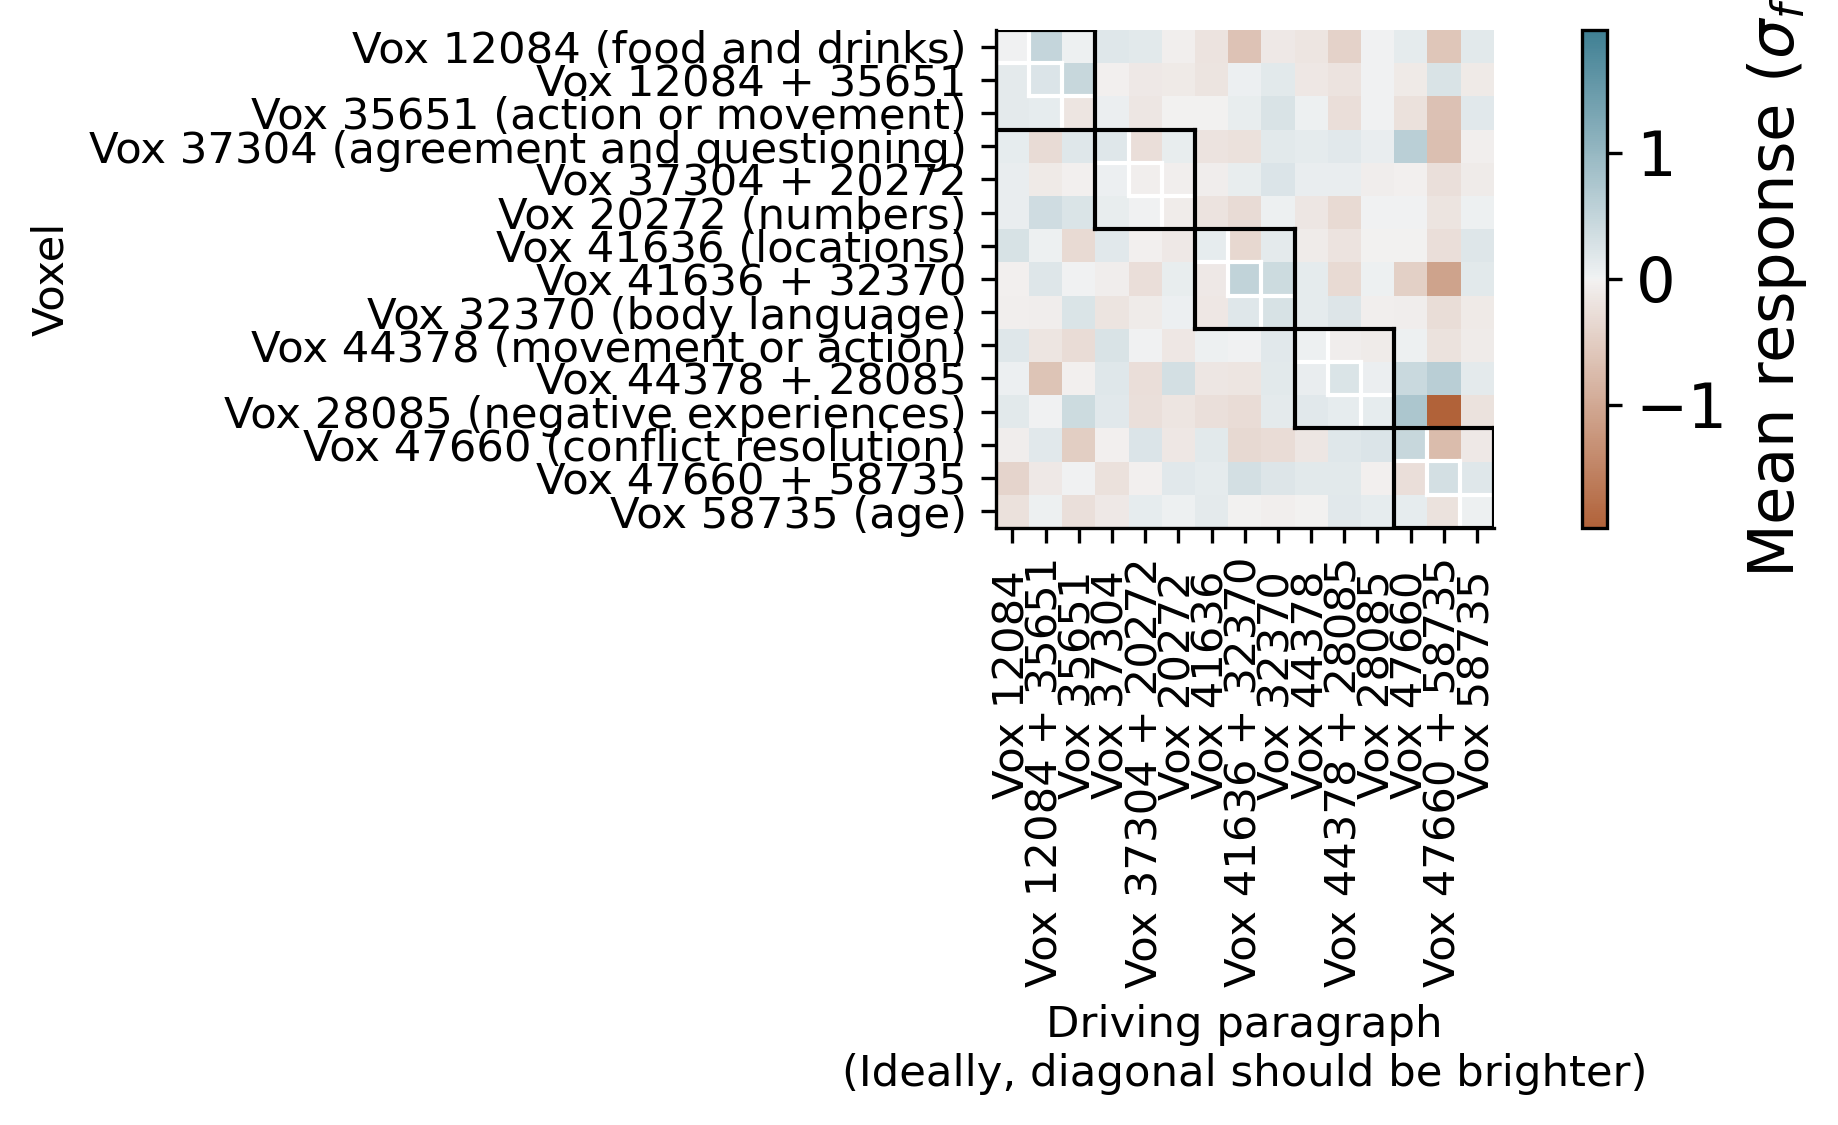

In [6]:
# note: some voxels didn't have good clusters so they will be missing from these plots...
# use_clusters = False
m1 = m[use_clusters]
plt.figure(figsize=(7, 4), dpi=300)


sasc.viz.outline_diagonal(m1.shape, color='white', lw=1, block_size=1)
sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=3)

# expls_order = analyze_helper.sort_expls_semantically(expls)
# expls_order = np.arange(len(expls))
m_plot = m1
# m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]
sasc.viz.imshow_diverging(m_plot)
plt.xlabel(
    "Driving paragraph\n(Ideally, diagonal should be brighter)", fontsize="x-small"
)
plt.ylabel("Voxel", fontsize="x-small")
vox_names = []

for i in range(1, len(story_metadata), 3):
    i3 = i // 3
    # vox_names.append("Vox " + str(voxel_num1[i3]) + " - " + str(voxel_num2[i3]))
    vox_names.append("Vox " + str(voxel_num1[i3]) + f' ({expl1[i3]})')
    vox_names.append(
        "Vox " + str(voxel_num1[i3]) + " + " + str(voxel_num2[i3]))
    # vox_names.append("Vox " + str(voxel_num2[i3]) + " - " + str(voxel_num1[i3]))
    vox_names.append("Vox " + str(voxel_num2[i3]) + f' ({expl2[i3]})')

vox_names_simple = [v.split('(')[0] for v in vox_names]

# remove spines
ax = plt.gca()
ax.spines["right"].set_visible(False)


# plt.yticks(labels=expls_with_num.values[expls_order], ticks=np.arange(len(expls)), fontsize='x-small')
plt.yticks(labels=vox_names, ticks=np.arange(
    len(vox_names)), fontsize="x-small")
plt.xticks(
    labels=vox_names_simple,
    ticks=np.arange(len(vox_names)),
    rotation=90,
    fontsize="x-small",
)
plt.savefig(join(RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_interaction_heatmap.pdf'))
plt.show()

In [26]:
voxel_num_zipped = np.array(list(zip(voxel_num1, voxel_num2))).flatten()
expl_zipped = np.array(list(zip(expl1, expl2))).flatten()

pd.DataFrame.from_dict({
    'vox': voxel_num_zipped,
    'expl': expl_zipped,
})

,vox,expl
0,12084,food and drinks
1,35651,action or movement
2,37304,agreement and questioning
3,20272,numbers
4,41636,locations
5,32370,body language
6,44378,movement or action
7,28085,negative experiences
8,47660,conflict resolution
9,58735,age


### Story-level differences

<>:19: DeprecationWarning: invalid escape sequence '\s'
<>:19: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_2366458/3526286735.py:19: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response target ($\sigma_f$)')


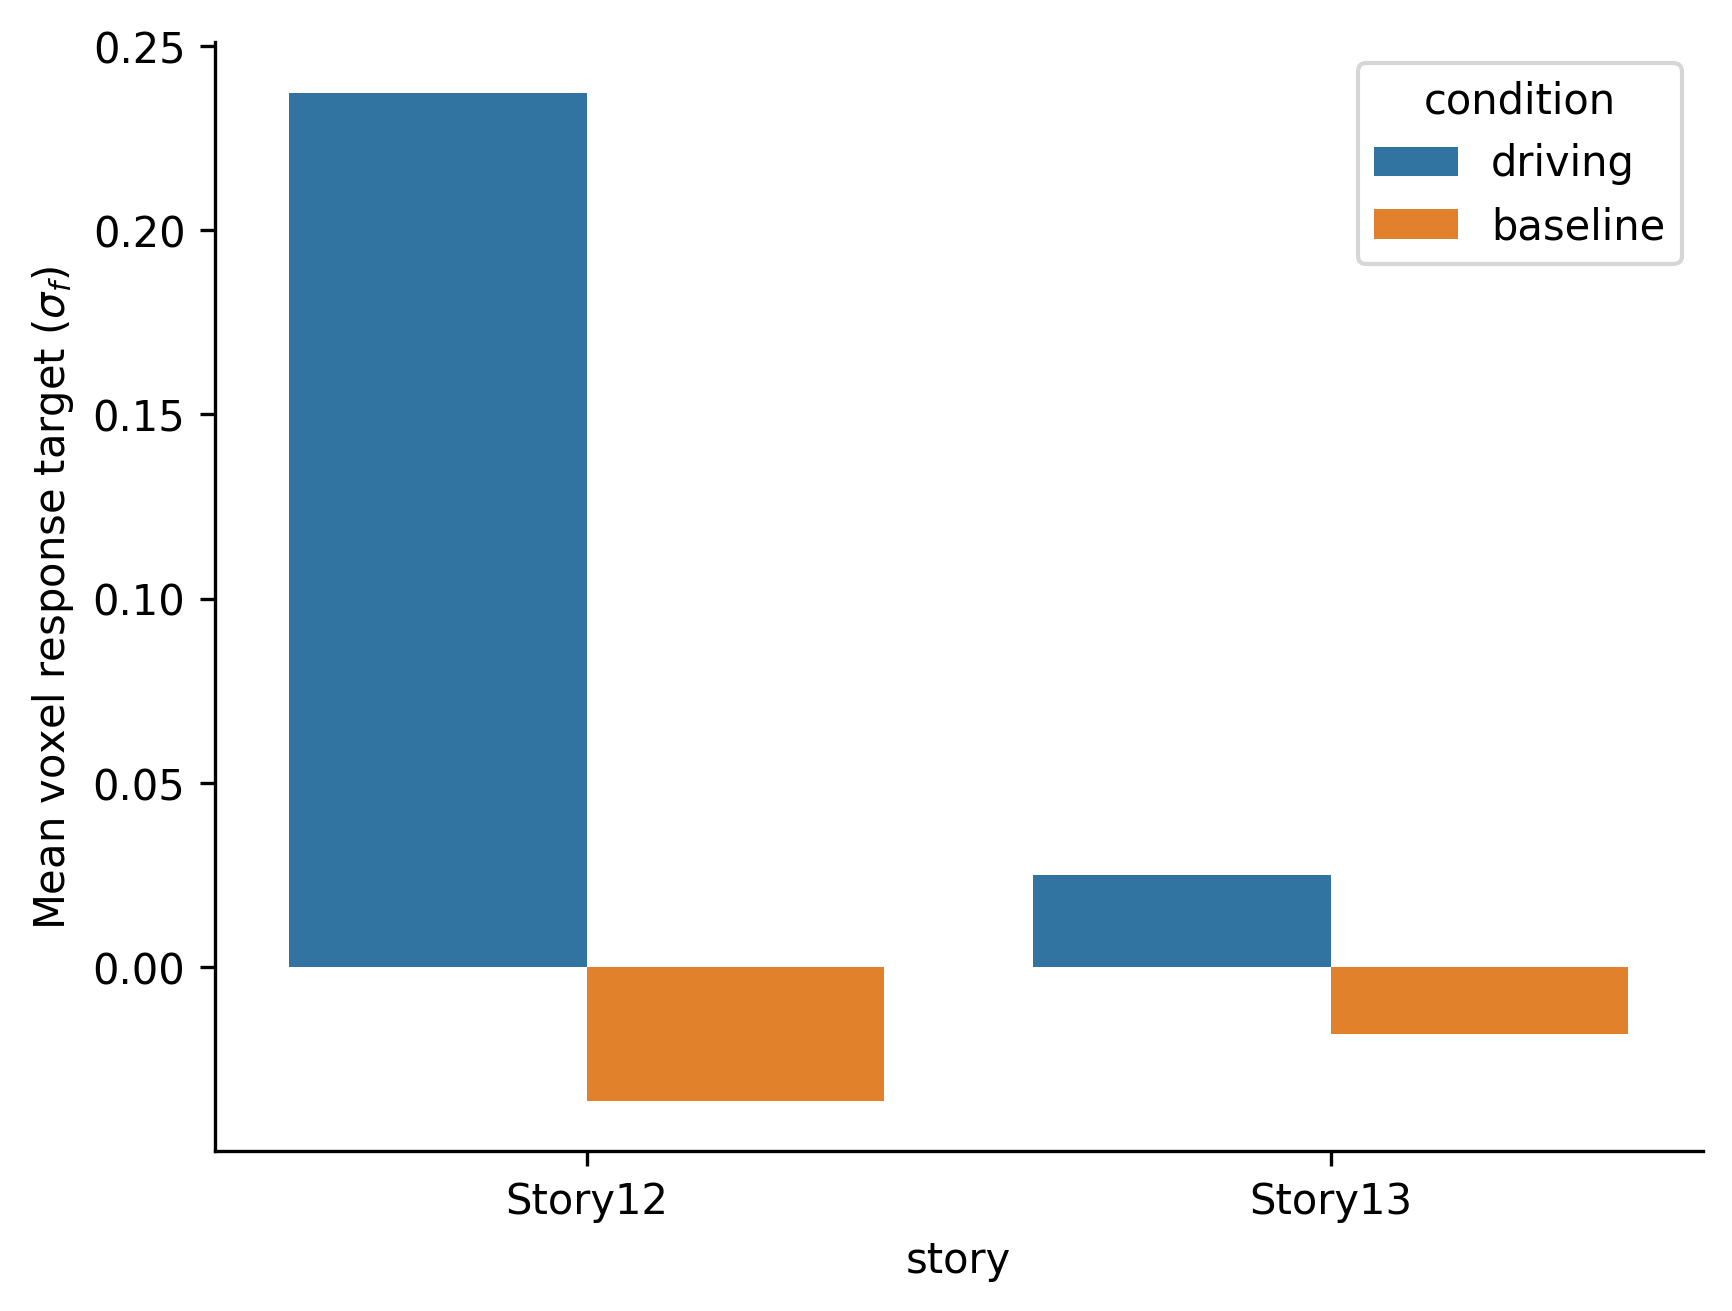

In [27]:
use_clusters = False
mats1 = mats_target[use_clusters]

d = defaultdict(list)
for i in range(len(mats1)):
    m = mats1[i]
    d['driving'].append(np.nanmean(np.diag(m)))
    d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
    d['story'].append(stories_data_dict['story_name_new'][i][3:-10])

df = pd.DataFrame.from_dict(d)

# make barplot comparing driving and baseline
df = df.melt(id_vars='story', value_vars=[
             'driving', 'baseline'], var_name='condition', value_name='mean')
df = df.sort_values(by='story')
plt.figure(dpi=300)
sns.barplot(data=df, x='story', y='mean', hue='condition')
plt.ylabel('Mean voxel response target ($\sigma_f$)')
plt.savefig(join(RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_interaction_story_breakdown.pdf'))
plt.show()